In [ ]:
'''
PReprocessing and feautre engineering on metadata using new abstract feature,
saving results as parquet file and TF-IDF features for text analysis and 
eventual kmeans. Split 70% training, 10% test, 20% pseudo real-world validation
All saved to S3. 
'''

In [2]:
# Library imports, setup, etc.
import boto3
import sagemaker
import json
import pandas as pd
import awswrangler as wr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[02/19/25 20:57:31] INFO     Found credentials from IAM Role:                                   ]8;id=641367;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=898142;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
sns.set(style="whitegrid")

# Configuration
bucket_name = "arxiv-project-bucket"
data_key = "arxiv-metadata-oai-snapshot.json"
role = "arn:aws:iam::221082214706:role/MYLabRole"
region = "us-east-1"

sess = sagemaker.Session(boto_session=boto3.Session(region_name=region))
print("Bucket:", bucket_name)

[02/19/25 20:57:49] INFO     Found credentials from IAM Role:                                   ]8;id=806298;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=573775;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Bucket: arxiv-project-bucket


In [4]:
# Chunk Processing Function, cannot load in all data at once 
def process_in_chunks(bucket, key, chunk_size=100000):
    """
    Generator reads in newline-delimited JSON file from S3
    """
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key=key)
    chunk = []
    for i, line in enumerate(obj['Body'].iter_lines()):
        if line:
            record = json.loads(line.decode('utf-8'))
            chunk.append(record)
            if len(chunk) >= chunk_size:
                yield pd.DataFrame(chunk)
                chunk = []
    if chunk:
        yield pd.DataFrame(chunk)

In [7]:
'''
Process Data in Chunks and Write Splits Individually
# We will process each chunk, compute TF-IDF on that chunk,
# split the chunk into train/test/real-world parts, and then write each part separately.
'''

chunk_size = 100000
chunk_index = 0

In [9]:
# Splits directly to S3

for df_chunk in process_in_chunks(bucket_name, data_key, chunk_size=chunk_size):
    print(f"Processing chunk {chunk_index} with shape: {df_chunk.shape}")
    
    # Basic preprocessing for each chunk
    df_chunk["title"] = df_chunk["title"].fillna("")
    df_chunk["abstract"] = df_chunk["abstract"].fillna("")
    df_chunk["text"] = df_chunk["title"] + " " + df_chunk["abstract"]
    
    # Compute TF-IDF features for this chunk
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df_chunk["text"])
    print("TF-IDF matrix shape for chunk:", tfidf_matrix.shape)
    
    # Select top 10 TF-IDF features for this chunk
    feature_names = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    df_features = pd.concat([df_chunk.reset_index(drop=True), tfidf_df.iloc[:, :10]], axis=1)
    
    # Split the chunk to roughly our percentages
    df_train_chunk, df_temp_chunk = train_test_split(df_features, test_size=0.3, random_state=39)
    df_test_chunk, df_realworld_chunk = train_test_split(df_temp_chunk, test_size=0.6667, random_state=39)
    
    print(f"Chunk {chunk_index} split shapes:")
    print("  Train:", df_train_chunk.shape)
    print("  Test:", df_test_chunk.shape)
    print("  Real-world:", df_realworld_chunk.shape)
    
    # Write each split directly to S3 
    
    wr.s3.to_parquet(
        df=df_train_chunk,
        path=f"s3://{bucket_name}/processed/train/arxiv_train_chunk_{chunk_index}.parquet",
        dataset=True,
        mode="overwrite",
        compression="snappy"
    )
    wr.s3.to_parquet(
        df=df_test_chunk,
        path=f"s3://{bucket_name}/processed/test/arxiv_test_chunk_{chunk_index}.parquet",
        dataset=True,
        mode="overwrite",
        compression="snappy"
    )
    wr.s3.to_parquet(
        df=df_realworld_chunk,
        path=f"s3://{bucket_name}/processed/realworld/arxiv_realworld_chunk_{chunk_index}.parquet",
        dataset=True,
        mode="overwrite",
        compression="snappy"
    )
    
    print(f"Chunk {chunk_index} files written directly to S3.")
    chunk_index += 1

[02/19/25 21:37:13] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=153360;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=786312;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

Processing chunk 0 with shape: (100000, 14)
TF-IDF matrix shape for chunk: (100000, 1000)
Chunk 0 split shapes:
  Train: (70000, 25)
  Test: (9999, 25)
  Real-world: (20001, 25)
Chunk 0 files written directly to S3.
Processing chunk 1 with shape: (100000, 14)
TF-IDF matrix shape for chunk: (100000, 1000)
Chunk 1 split shapes:
  Train: (70000, 25)
  Test: (9999, 25)
  Real-world: (20001, 25)
Chunk 1 files written directly to S3.
Processing chunk 2 with shape: (100000, 14)
TF-IDF matrix shape for chunk: (100000, 1000)
Chunk 2 split shapes:
  Train: (70000, 25)
  Test: (9999, 25)
  Real-world: (20001, 25)
Chunk 2 files written directly to S3.
Processing chunk 3 with shape: (100000, 14)
TF-IDF matrix shape for chunk: (100000, 1000)
Chunk 3 split shapes:
  Train: (70000, 25)
  Test: (9999, 25)
  Real-world: (20001, 25)
Chunk 3 files written directly to S3.
Processing chunk 4 with shape: (100000, 14)
TF-IDF matrix shape for chunk: (100000, 1000)
Chunk 4 split shapes:
  Train: (70000, 25)
  T

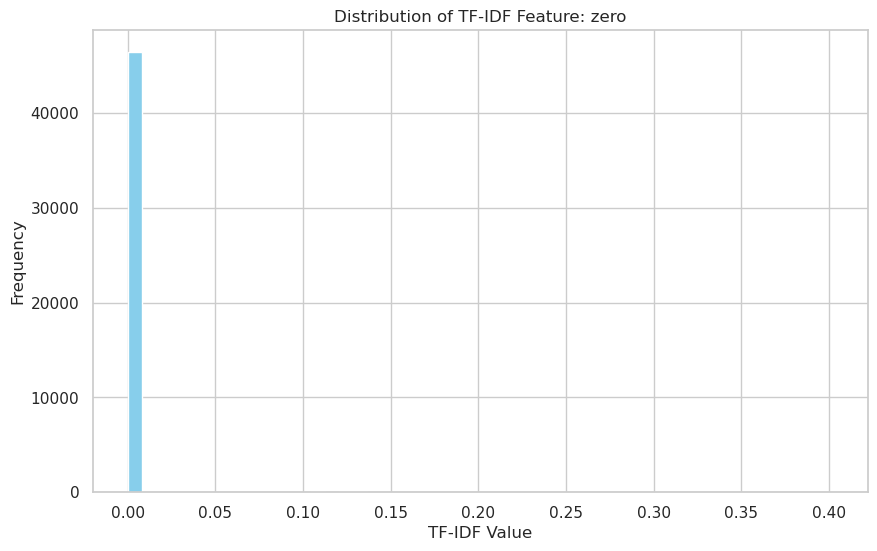

In [10]:
# Visualize an Example TF-IDF Feature Distribution from the Last Chunk Processed
plt.figure(figsize=(10,6))
plt.hist(df_features.iloc[:, -1], bins=50, color='skyblue')
plt.title("Distribution of TF-IDF Feature: " + feature_names[-1])
plt.xlabel("TF-IDF Value")
plt.ylabel("Frequency")
plt.show()